In [1]:
# Import PyTorch
import torch
from torch import nn

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_projects_2\ml_basic_pytorch\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.1.2+cu118
torchvision version: 0.16.2+cu118


### Device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### MNIST download from pytorch datasets

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
image, label = train_data[0]

In [5]:
image.shape

torch.Size([1, 28, 28])

In [6]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


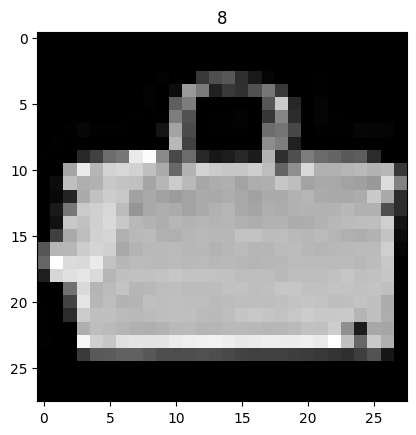

In [7]:
import matplotlib.pyplot as plt
image, label = train_data[99]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

### DataLoader

In [8]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 128

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001B8AFDFE0B0>, <torch.utils.data.dataloader.DataLoader object at 0x000001B8AFDFE4A0>)
Length of train dataloader: 469 batches of 128
Length of test dataloader: 79 batches of 128


In [9]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

#### Random image from batch

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


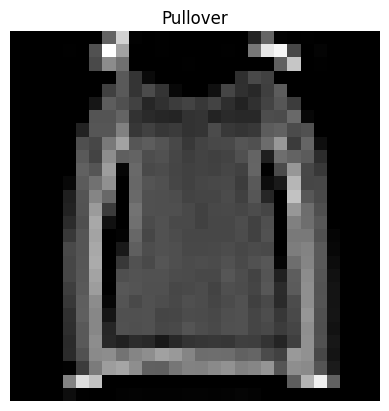

In [10]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [11]:
from torch import nn
class FashionModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.model(x)

In [12]:
model_0 = FashionModelV0(
    input_shape = 28*28,
    hidden_units = 100,
    output_shape=len(class_names)
)
model_0.to(device)

FashionModelV0(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
  )
)

#### Helper functions

In [13]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [14]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

In [15]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating a function to time our experiments

In [16]:

from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Functionized training and testing steps

In [17]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [18]:
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|                                                                                                                                                       | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.04816 | Train accuracy: 67.08%


 33%|███████████████████████████████████████████████▋                                                                                               | 1/3 [00:04<00:08,  4.35s/it]

Test loss: 0.76194 | Test accuracy: 75.00%

Epoch: 1
---------
Train loss: 0.69971 | Train accuracy: 76.94%


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2/3 [00:08<00:04,  4.46s/it]

Test loss: 0.71219 | Test accuracy: 76.29%

Epoch: 2
---------
Train loss: 0.64949 | Train accuracy: 78.12%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.47s/it]

Test loss: 0.68493 | Test accuracy: 77.23%

Train time on cuda: 13.407 seconds


### Function to evaluate model results

In [20]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionModelV0',
 'model_loss': 0.6849288940429688,
 'model_acc': 77.22507911392405}

### Using CNNs

In [29]:
class FashionCNNModel(nn.Module):
    """
    Based on the TinyVGG model
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
model_2 = FashionCNNModel(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2 

FashionCNNModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### Shapes
input image is 28 x 28
Maxpool with kernel 2 divides by /2
28 /2 /2 = 7
output features are 7x7
7x7 x hidden_units

you can also run a test to print how the shapes change during a forward pass

In [25]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [30]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[-0.0548,  0.0372,  0.0177,  0.0535, -0.0364,  0.0044, -0.0111,  0.0026,
          0.0523,  0.0356]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Loss fn
remember, optimizer has to be set on the model params

In [33]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [34]:
# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|                                                                                                                                                       | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.02214 | Train accuracy: 63.31%


 33%|███████████████████████████████████████████████▋                                                                                               | 1/3 [00:05<00:10,  5.13s/it]

Test loss: 0.47727 | Test accuracy: 82.94%

Epoch: 1
---------
Train loss: 0.44001 | Train accuracy: 84.03%


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2/3 [00:10<00:05,  5.07s/it]

Test loss: 0.43489 | Test accuracy: 84.15%

Epoch: 2
---------
Train loss: 0.38001 | Train accuracy: 86.25%


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

Test loss: 0.40787 | Test accuracy: 85.17%

Train time on cuda: 15.131 seconds


In [35]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionCNNModel',
 'model_loss': 0.40786755084991455,
 'model_acc': 85.16613924050633}

In [36]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionModelV0,0.684929,77.225079
1,FashionCNNModel,0.407868,85.166139


In [37]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionModelV0,0.684929,77.225079,13.406853
1,FashionCNNModel,0.407868,85.166139,15.131266


In [39]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_2, input_size=[1, 1, 28, 28]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
FashionCNNModel                          [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─ReLU: 2-2                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 10, 28, 28]           910
│    └─ReLU: 2-4                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 10, 14, 14]           910
│    └─ReLU: 2-7                         [1, 10, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 10, 14, 14]           910
│    └─ReLU: 2-9                         [1, 10, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 10, 7, 7]             --
├─Sequentia